In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import time 

from lfimodels.balancednetwork.BalancedNetworkSimulator import BalancedNetwork
from lfimodels.balancednetwork.BalancedNetworkStats import BalancedNetworkStats
from lfimodels.balancednetwork.BalancedNetworkGenerator import BalancedNetworkGenerator

%matplotlib inline

### Define the objects we need for the simulation: 

model, prior, summarystats, a generator to combine it all

The parameter we use for the balanced network simulation is the clustering coef $R_{ee}$. For now we want this to be very close around 1. 

In [2]:
n_params = 1
n_cores_to_use = 12

m = BalancedNetwork(dim=n_params, first_port=8010, 
                    verbose=True, n_servers=n_cores_to_use, duration=3.)
p = dd.Uniform(lower=[0.5], upper=[5.])
s = BalancedNetworkStats(n_workers=n_cores_to_use)
g = BalancedNetworkGenerator(model=m, prior=p, summary=s)

### Make a test by running one sample = one simulation 

The generator returns the params used and the correspoding stats: the theta-x tuples used by the MDN. 

In [3]:
# here we set the true params 
true_params = [[2.5]]
# run forward model 
data = m.gen(true_params)
# get summary stats
stats_obs = s.calc(data[0])

starting 1 / 1. total time remaining: ca. 0.5min 
Done


In [4]:
print(true_params, stats_obs)

[[2.5]] [[  1.08207174e+00   4.44781250e+00   2.08333333e+00   2.71623518e+01
    4.29556495e-03]]


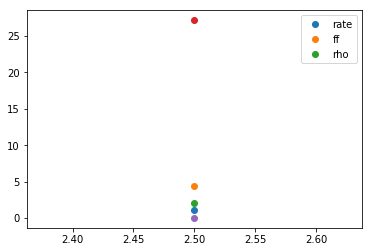

In [5]:
plt.plot(true_params, stats_obs, 'o')
plt.legend(['rate', 'ff', 'rho']);

In [6]:
# set up inference
res = infer.Basic(g, n_components=3, pilot_samples=50)

starting 7 / 50. total time remaining: ca. 2.0min 
starting 5 / 50. total time remaining: ca. 2.0min 
starting 9 / 50. total time remaining: ca. 2.0min 
starting 3 / 50. total time remaining: ca. 2.0min 
starting 11 / 50. total time remaining: ca. 2.0min 
starting 15 / 50. total time remaining: ca. 1.5min 
starting 13 / 50. total time remaining: ca. 2.0min 
starting 1 / 50. total time remaining: ca. 2.5min 
starting 17 / 50. total time remaining: ca. 1.5min 
starting 21 / 50. total time remaining: ca. 1.5min 
starting 23 / 50. total time remaining: ca. 1.5min 
starting 19 / 50. total time remaining: ca. 1.5min 
starting 2 / 50. total time remaining: ca. 2.0min 
starting 12 / 50. total time remaining: ca. 2.0min 
starting 10 / 50. total time remaining: ca. 2.0min 
starting 8 / 50. total time remaining: ca. 2.0min 
starting 4 / 50. total time remaining: ca. 2.0min 
starting 6 / 50. total time remaining: ca. 2.0min 
starting 25 / 50. total time remaining: ca. 1.5min 
starting 27 / 50. tot

In [7]:
ntrain = 700
# run with N samples, for N=100 this will take 2000s = 0.6h
out, trn_data = res.run(ntrain, epochs=1000, minibatch=50)

starting 31 / 700. total time remaining: ca. 28.0min 
starting 121 / 700. total time remaining: ca. 24.5min 
starting 1 / 700. total time remaining: ca. 29.5min 
starting 16 / 700. total time remaining: ca. 28.5min 
starting 61 / 700. total time remaining: ca. 27.0min 
starting 46 / 700. total time remaining: ca. 27.5min 
starting 91 / 700. total time remaining: ca. 25.5min 
starting 76 / 700. total time remaining: ca. 26.0min 
starting 106 / 700. total time remaining: ca. 25.0min 
starting 136 / 700. total time remaining: ca. 23.5min 
starting 151 / 700. total time remaining: ca. 23.0min 
starting 166 / 700. total time remaining: ca. 22.5min 
starting 2 / 700. total time remaining: ca. 29.0min 
starting 47 / 700. total time remaining: ca. 27.5min 
starting 17 / 700. total time remaining: ca. 28.5min 
starting 32 / 700. total time remaining: ca. 28.0min 
starting 3 / 700. total time remaining: ca. 29.0min 
starting 33 / 700. total time remaining: ca. 28.0min 
starting 107 / 700. total 

starting 132 / 700. total time remaining: ca. 24.0min 
starting 59 / 700. total time remaining: ca. 27.0min 
starting 118 / 700. total time remaining: ca. 24.5min 
starting 103 / 700. total time remaining: ca. 25.0min 
starting 73 / 700. total time remaining: ca. 26.5min 
starting 148 / 700. total time remaining: ca. 23.0min 
starting 178 / 700. total time remaining: ca. 22.0min 
starting 30 / 700. total time remaining: ca. 28.0min 
starting 163 / 700. total time remaining: ca. 22.5min 
starting 60 / 700. total time remaining: ca. 27.0min 
starting 89 / 700. total time remaining: ca. 25.5min 
starting 15 / 700. total time remaining: ca. 28.5min 
starting 104 / 700. total time remaining: ca. 25.0min 
starting 133 / 700. total time remaining: ca. 24.0min 
starting 119 / 700. total time remaining: ca. 24.5min 
starting 74 / 700. total time remaining: ca. 26.0min 
starting 45 / 700. total time remaining: ca. 27.5min 
starting 179 / 700. total time remaining: ca. 22.0min 
starting 105 / 700

starting 251 / 700. total time remaining: ca. 19.0min 
starting 310 / 700. total time remaining: ca. 16.5min 
starting 192 / 700. total time remaining: ca. 21.5min 
starting 266 / 700. total time remaining: ca. 18.0min 
starting 222 / 700. total time remaining: ca. 20.0min 
starting 237 / 700. total time remaining: ca. 19.5min 
starting 296 / 700. total time remaining: ca. 17.0min 
starting 281 / 700. total time remaining: ca. 17.5min 
starting 340 / 700. total time remaining: ca. 15.0min 
starting 355 / 700. total time remaining: ca. 14.5min 
starting 207 / 700. total time remaining: ca. 20.5min 
starting 252 / 700. total time remaining: ca. 19.0min 
starting 326 / 700. total time remaining: ca. 15.5min 
starting 311 / 700. total time remaining: ca. 16.5min 
starting 297 / 700. total time remaining: ca. 17.0min 
starting 193 / 700. total time remaining: ca. 21.5min 
starting 238 / 700. total time remaining: ca. 19.5min 
starting 282 / 700. total time remaining: ca. 17.5min 
starting 3

starting 517 / 700. total time remaining: ca. 8.0min 
starting 384 / 700. total time remaining: ca. 13.5min 
starting 532 / 700. total time remaining: ca. 7.0min 
starting 458 / 700. total time remaining: ca. 10.0min 
starting 399 / 700. total time remaining: ca. 12.5min 
starting 429 / 700. total time remaining: ca. 11.5min 
starting 370 / 700. total time remaining: ca. 14.0min 
starting 488 / 700. total time remaining: ca. 9.0min 
starting 444 / 700. total time remaining: ca. 11.0min 
starting 474 / 700. total time remaining: ca. 9.5min 
starting 503 / 700. total time remaining: ca. 8.5min 
starting 385 / 700. total time remaining: ca. 13.5min 
starting 415 / 700. total time remaining: ca. 12.0min 
starting 400 / 700. total time remaining: ca. 12.5min 
starting 518 / 700. total time remaining: ca. 7.5min 
starting 533 / 700. total time remaining: ca. 7.0min 
starting 459 / 700. total time remaining: ca. 10.0min 
starting 489 / 700. total time remaining: ca. 9.0min 
starting 504 / 700

starting 680 / 700. total time remaining: ca. 1.0min 
starting 651 / 700. total time remaining: ca. 2.0min 
starting 562 / 700. total time remaining: ca. 6.0min 
starting 592 / 700. total time remaining: ca. 4.5min 
starting 621 / 700. total time remaining: ca. 3.5min 
starting 578 / 700. total time remaining: ca. 5.0min 
starting 696 / 700. total time remaining: ca. 0.5min 
starting 637 / 700. total time remaining: ca. 3.0min 
starting 607 / 700. total time remaining: ca. 4.0min 
starting 548 / 700. total time remaining: ca. 6.5min 
starting 666 / 700. total time remaining: ca. 1.5min 
starting 563 / 700. total time remaining: ca. 6.0min 
starting 652 / 700. total time remaining: ca. 2.0min 
starting 579 / 700. total time remaining: ca. 5.0min 
starting 622 / 700. total time remaining: ca. 3.5min 
starting 681 / 700. total time remaining: ca. 1.0min 
starting 593 / 700. total time remaining: ca. 4.5min 
starting 697 / 700. total time remaining: ca. 0.5min 
starting 638 / 700. total ti

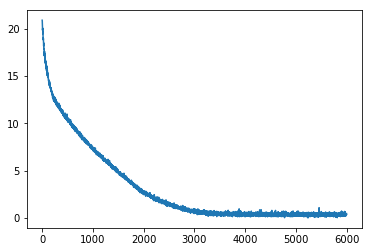

In [14]:
plt.plot(out['loss']);

## Test the result: generate an observation and compare it to simulations from the posterior

In [9]:
# evaluate the posterior at the observed data 
posterior = res.predict(stats_obs)

In [10]:
# set up a dict for saving the results 
save_data = True
path_to_save_folder = 'data/'  # has to exist on your local path

if save_data and os.path.exists(path_to_save_folder): 
    nrounds=1
    result_dict = dict(true_params=true_params, stats_obs=stats_obs, nrouns=nrounds, ntrain=ntrain,
                       posterior=posterior, out=out, trn_data=trn_data)
    
    filename = os.path.join(path_to_save_folder, 
                           '{}_basic_ntrain{}'.format(time.time(), ntrain).replace('.', '') + '.p')
    with open(filename, 'wb') as handle:
        pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(filename)

data/15035660012480164_basic_ntrain700.p


In [11]:
# extract the posterior 
n_components = len(posterior.a)
means = [posterior.xs[c].m for c in range(n_components)]
Ss = [posterior.xs[c].S for c in range(n_components)]

In [12]:
theta = np.linspace(0, 5, 1000)
sub_means = [[means[c][0]] for c in range(n_components)]
sub_cov = np.asarray([Ss[c] for c in range(n_components)])
pdf = dd.mixture.MoG(a=posterior.a, ms=sub_means, Ss=sub_cov)
post_pdf = pdf.eval(theta[:, np.newaxis], log=False)

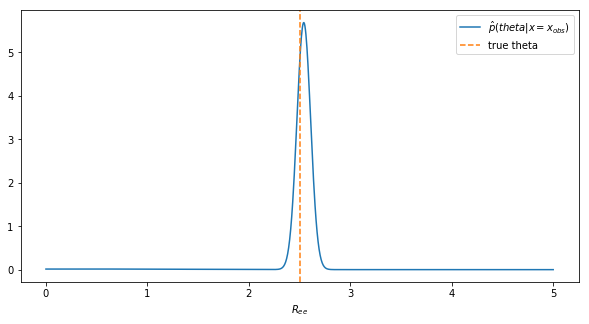

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(theta, post_pdf, label='$\hat{p}( theta | x=x_{obs})$')
plt.axvline(x=true_params[0], label='true theta', linestyle='--', color='C1')
plt.legend()
plt.xlabel('$R_{ee}$');